In [1]:
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn
# %pip install numpy

# Visualization and data exploration

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv( '../data/data_1.csv' )
print( 'Bacteria:', data.shape[0] )
print( 'Patients:', data.shape[1] )
data.head()

Bacteria: 5619
Patients: 61


,Taxonomy,A3,A5,A6,A9,A31,A51,A52,A53,A54,...,B120,B127,B132,B141,B142,B143,B152,B156,B158,B164
0,g__Faecalibacterium;s__Faecalibacterium prausn...,4988,5060,2905,5745,4822,3889,4646,6337,5064,...,4471,5868,6561,4910,4492,2812,5303,4205,3430,4563
1,g__Hungatella;s__Hungatella hathewayi,5803,5612,4109,1432,2652,4175,3891,894,4903,...,2126,4429,2598,4222,4925,5753,1261,1822,2478,4868
2,g__Clostridium;s__uncultured Clostridium sp.,3793,2795,1355,5558,5383,3505,5541,4429,4121,...,4085,6041,6188,3960,4403,2841,2746,3808,3856,3211
3,g__Butyricimonas;s__Butyricimonas virosa,64,1385,725,1553,40,53,33,175,58,...,2065,21,27,55,35,8,884,13,3,218
4,g__Alistipes;s__Alistipes indistinctus,15,20,723,620,3261,43,83,37,43,...,90,22,30,1027,2641,4,1587,2223,6,1473


In [3]:
data.drop( 'Taxonomy', axis = 1, inplace = True )
data = data.T
data.columns = pd.read_csv( '../data/data_1.csv' )[ 'Taxonomy' ]
data.rename_axis( 'Patient', axis = 1, inplace = True )
data.head()

Patient,g__Faecalibacterium;s__Faecalibacterium prausnitzii,g__Hungatella;s__Hungatella hathewayi,g__Clostridium;s__uncultured Clostridium sp.,g__Butyricimonas;s__Butyricimonas virosa,g__Alistipes;s__Alistipes indistinctus,g__Unclassified;s__Firmicutes bacterium CAG:176,g__Clostridium;s__Clostridium sp. CAG:7,g__Unclassified;s__Firmicutes bacterium CAG:882,g__Lachnoclostridium;s__[Clostridium] asparagiforme,g__Butyricicoccus;s__uncultured Butyricicoccus sp.,...,g__Unclassified;s__Clostridium phage c-st,g__Unclassified;s__Enterococcus phage EFDG1,g__Unclassified;s__Podovirus Lau218,g__Sap6virus;s__Enterococcus phage VD13,g__Unclassified;s__Bacillus phage vB_BanS-Tsamsa,g__Unclassified;s__Gordonia phage GTE2,g__Alphabaculovirus;s__Hyphantria cunea nucleopolyhedrovirus,g__Potyvirus;s__Bean common mosaic virus,g__Potyvirus;s__Telosma mosaic virus,g__Unclassified;s__Freshwater phage uvFW-CGR-AMD-COM-C203
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,0,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Check for and omit absent species
data.drop( columns = data.columns[ data.sum() == 0 ], inplace = True )
data.head()

Patient,g__Faecalibacterium;s__Faecalibacterium prausnitzii,g__Hungatella;s__Hungatella hathewayi,g__Clostridium;s__uncultured Clostridium sp.,g__Butyricimonas;s__Butyricimonas virosa,g__Alistipes;s__Alistipes indistinctus,g__Unclassified;s__Firmicutes bacterium CAG:176,g__Clostridium;s__Clostridium sp. CAG:7,g__Unclassified;s__Firmicutes bacterium CAG:882,g__Lachnoclostridium;s__[Clostridium] asparagiforme,g__Butyricicoccus;s__uncultured Butyricicoccus sp.,...,g__Unclassified;s__Deep-sea thermophilic phage D6E,g__Unclassified;s__Environmental Halophage eHP-30,g__Unclassified;s__Flavobacterium phage FKj-2,g__Unclassified;s__Geobacillus virus E2,g__Unclassified;s__Salmonella phage 64795_sal3,g__Unclassified;s__Skermania phage SPI1,g__Unclassified;s__Vibrio phage vB_VhaS-tm,g__Unclassified;s__uncultured Mediterranean phage uvDeep-CGR0-AD1-C123,g__Unclassified;s__uncultured Mediterranean phage uvDeep1-CGR2-KM23-C896,g__Unclassified;s__uncultured virus
A3,4988,5803,3793,64,15,100,2119,12,453,1266,...,0,0,0,0,0,0,0,0,0,0
A5,5060,5612,2795,1385,20,29,1230,24,691,1682,...,0,0,0,0,0,0,0,0,0,0
A6,2905,4109,1355,725,723,11,1322,1,2278,43,...,0,0,0,0,0,0,0,0,0,0
A9,5745,1432,5558,1553,620,1320,2675,44,107,1726,...,0,0,0,0,0,0,0,0,1,0
A31,4822,2652,5383,40,3261,51,1470,26,342,1804,...,0,0,0,0,0,0,0,0,0,0


In [5]:
target = data.index.to_list()
binary_target = np.array( [ 0 if t.startswith( 'A' ) else 1 for t in target ] )
binary_target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
x = pd.concat( [data[:10], data[30:40]] )
x = x.iloc[:, ::20]
corrm = x.corr()
for i in corrm:
    sorted = corrm[i].sort_values( ascending = False, key = lambda x: abs(x) )
    print( i )
    print( { sorted.index[j]: sorted[j].item() for j in range(1, 5) } )
    print()

g__Faecalibacterium;s__Faecalibacterium prausnitzii
{'g__Streptococcus;s__Streptococcus equi': 0.6712165029020911, 'g__Methanosarcina;s__Methanosarcina siciliae': 0.6449516565671735, 'g__Paenibacillus;s__Paenibacillus daejeonensis': 0.6058040821274248, 'g__Butyrivibrio;s__Butyrivibrio sp. Su6': 0.6037930223081724}

g__Clostridium;s__Clostridium sp. CAG:127
{'g__Desulfotomaculum;s__Desulfotomaculum nigrificans': 0.7433134165610685, 'g__Helicobacter;s__Helicobacter suis': 0.7254331525848124, 'g__Pseudomonas;s__Pseudomonas stutzeri': 0.7191631195266697, 'g__Unclassified;s__Firmicutes bacterium CAG:321': 0.6498323637858692}

g__Eubacterium;s__Eubacterium sp. CAG:202
{'g__Bacteroides;s__Bacteroides sp. Marseille-P2824': 0.8460585424463258, 'g__Listeria;s__Listeria marthii': 0.7854654964369226, 'g__Paenibacillus;s__Paenibacillus jilunlii': 0.7854654964369226, 'g__Proteus;s__Proteus vulgaris': 0.7854654964369226}

g__Coprobacillus;s__Coprobacillus sp. CAG:605
{'g__Ruminococcus;s__Ruminococcus

/tmp/ipykernel_10948/1099127218.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print( { sorted.index[j]: sorted[j].item() for j in range(1, 5) } )


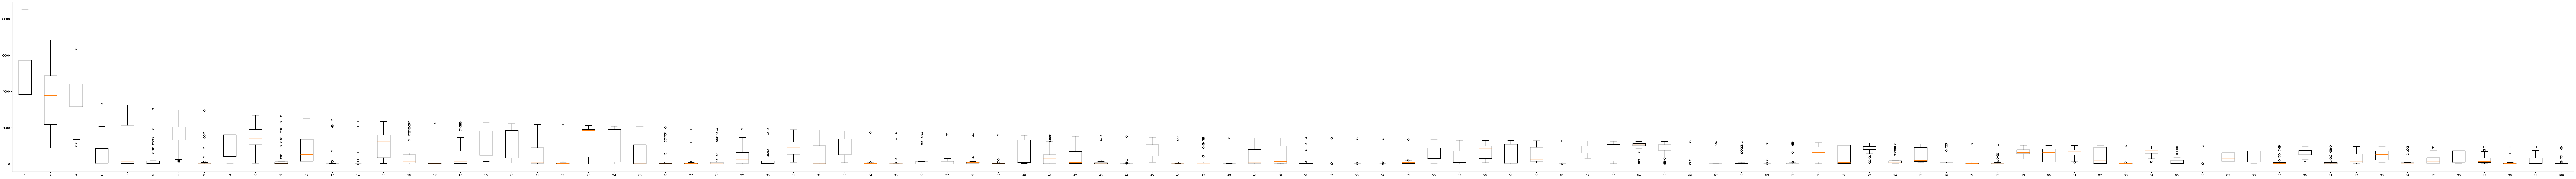

In [8]:
plt.figure( figsize = ( 150, 10 ) )
plt.boxplot( data.iloc[ :, :100 ] )
plt.savefig( "../output/boxplot.png", bbox_inches = 'tight', dpi = 100 )

In [7]:
data_subset = data.sample( axis = 1, n = 100 )
a_group = data_subset[:30]
b_group = data_subset[30:]
a_group.shape, b_group.shape

((30, 100), (30, 100))

In [8]:
a_corr = a_group.corr()
a_filtered_corr = a_corr[a_corr.abs() >= 0.2]

b_corr = b_group.corr()
b_filtered_corr = b_corr[b_corr.abs() >= 0.2]

In [ ]:
sz = 70
plt.figure( figsize = ( sz, sz ) )
sns.heatmap( a_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
plt.title( "A group filtered abs(corr) >= 0.2, 100 random" )
plt.savefig( "../output/a_filtered.png", bbox_inches = 'tight', dpi = 100 )
plt.show()

In [ ]:
plt.figure( figsize = ( sz, sz ) )
sns.heatmap( b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
plt.title( "B group filtered abs(corr) >= 0.2, 100 random" )
plt.savefig( "../output/b_filtered.png", bbox_inches = 'tight', dpi = 100 )
plt.show()

In [ ]:
plt.figure( figsize = ( sz, sz ) )
sns.heatmap( a_filtered_corr - b_filtered_corr, fmt = ".2f", annot = True, cmap = 'coolwarm', square = True, linewidths = 0.5 )
plt.title( "corr difference: A - B" )
plt.savefig( "../output/corr_diff.png", bbox_inches = 'tight', dpi = 100 )
plt.show()

# Model classification

In [94]:
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import warnings

SEED = 321 

In [79]:
# Lets put aside a small test set, so we can check performance of different classifiers against it
disease_train, disease_test, disease_y_train, disease_y_test = train_test_split(data, binary_target, test_size = 0.2, shuffle = True, random_state=SEED)   

In [21]:
print(disease_y_train.sum())
print(disease_test.shape)

23
(12, 5457)


In [62]:
rfc = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')

rfc.fit(disease_train, disease_y_train)

RandomForestClassifier(n_estimators=200, random_state=534)

In [ ]:
# rfc = XGBClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')

# rfc.fit(disease_train, disease_y_train)

In [63]:

most_important = sorted(list(enumerate(rfc.feature_importances_)), key=lambda k:-k[1])
most_important

[(349, 0.02825675839246931),
 (157, 0.018230051290246484),
 (35, 0.016891190536737714),
 (913, 0.016603358580530213),
 (488, 0.015880387716827392),
 (701, 0.015290418248154638),
 (178, 0.015190913441281751),
 (272, 0.014849617093781551),
 (213, 0.012938178334719384),
 (583, 0.012662215670492787),
 (120, 0.01178954754073331),
 (585, 0.010713520824710856),
 (460, 0.009915864991270526),
 (780, 0.009836549756413258),
 (177, 0.009446871010789051),
 (1294, 0.00944161123062448),
 (173, 0.009157473256794139),
 (426, 0.008339770297475655),
 (320, 0.008024354119801133),
 (798, 0.007961841211807139),
 (396, 0.007684459430522063),
 (377, 0.007541293583389579),
 (378, 0.007002294382581489),
 (653, 0.0069328440748730605),
 (181, 0.006793133922687826),
 (129, 0.00676533174243553),
 (333, 0.0063096903096903105),
 (1210, 0.006290131124913734),
 (635, 0.006246358398482337),
 (406, 0.006054138245954102),
 (87, 0.006022271525847911),
 (93, 0.005928571893210967),
 (437, 0.005746666032380317),
 (47, 0.00568

In [64]:
data.columns[[k[0] for k in most_important[:5]]]

Index(['g__Prevotella;s__Prevotella sp. CAG:1185',
       'g__Parabacteroides;s__Parabacteroides distasonis',
       'g__Prevotella;s__Prevotella sp. CAG:279',
       'g__Porphyromonas;s__Porphyromonas macacae',
       'g__Prevotella;s__Prevotella ruminicola'],
      dtype='object', name='Patient')

In [65]:
y_pred = rfc.predict(disease_test)
print(classification_report(disease_y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60         5
           1       0.71      0.71      0.71         7

    accuracy                           0.67        12
   macro avg       0.66      0.66      0.66        12
weighted avg       0.67      0.67      0.67        12



In [108]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
folds = enumerate(kfold.split(data, binary_target))


## Random forest

In [110]:
# f1_scores = []
roc_auc_scores = []
for fold, (train, test) in folds:
    print(f'Fold {fold}:')
    x_train, y_train = data.iloc[train], binary_target[train]
    x_test, y_test = data.iloc[test], binary_target[test]
    print(x_train.shape, x_test.shape)

    rfc = RandomForestClassifier(n_estimators=200, criterion='gini', random_state=534, max_features='sqrt')
    rfc.fit(x_train, y_train)

    y_pred = rfc.predict(x_test)
    # score = f1_score(y_test, y_pred)
    # f1_scores.append(score)
    # print(f'f1 score = {score}')

    roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc_scores.append(roc_auc)
    print(f'roc auc score = {roc_auc:.2f}')

    print()

roc_auc_scores = np.array(roc_auc_scores)
print('min: %.2f, max: %.2f, avg %.2f' % (roc_auc_scores.min(), roc_auc_scores.max(), roc_auc_scores.mean()))

Fold 1:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 2:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 3:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 4:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 5:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 6:
(54, 5457) (6, 5457)
roc auc score = 0.67

Fold 7:
(54, 5457) (6, 5457)
roc auc score = 0.83

Fold 8:
(54, 5457) (6, 5457)
roc auc score = 1.00

Fold 9:
(54, 5457) (6, 5457)
roc auc score = 0.67

min: 0.67, max: 1.00, avg 0.80
